# NFA prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
output_folder = './validation_report/NFA'
today = pd.Timestamp.today().strftime('%Y-%m-%d')

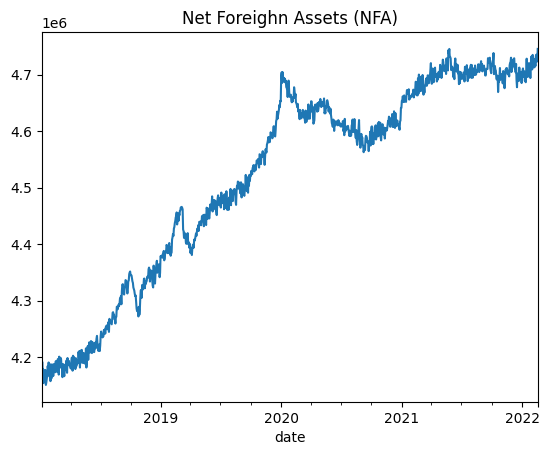

In [3]:
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')
NFA['NFA'].plot(title = 'Net Foreighn Assets (NFA)'); plt.show()

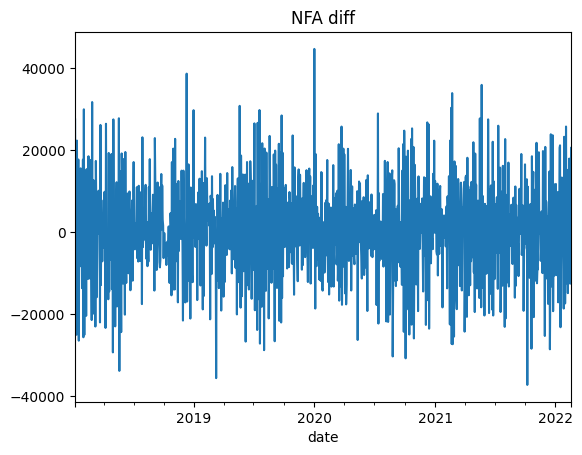

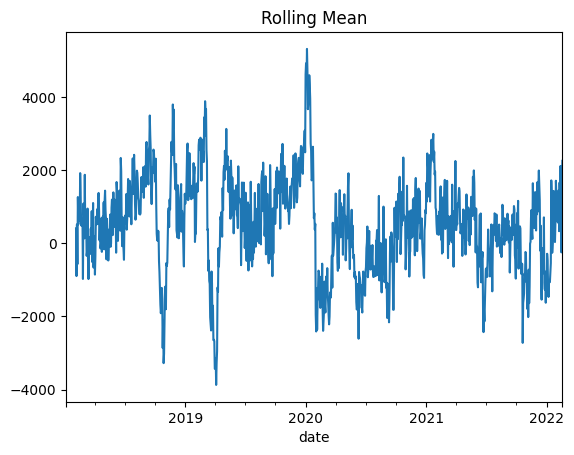

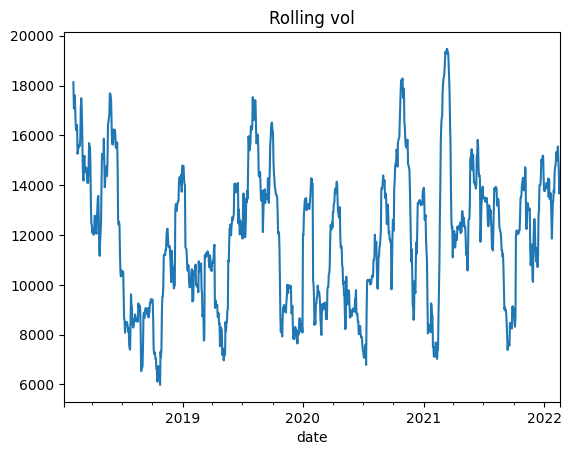

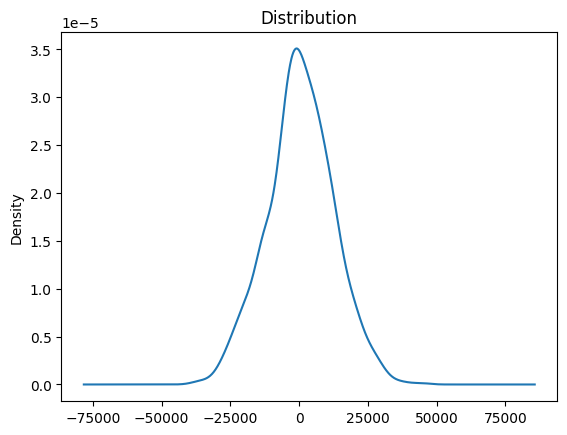

In [4]:
NFA_diff = NFA['NFA'].diff().dropna()
NFA_diff.plot(title = 'NFA diff');plt.show()
NFA_diff.rolling(22).mean().plot(title = 'Rolling Mean');plt.show()
NFA_diff.rolling(22).std().plot(title = 'Rolling vol');plt.show()
NFA_diff.plot(kind='kde', title = 'Distribution');plt.show()

In [5]:
dateindex = pd.date_range(start=NFA.index[0], 
                             end=NFA.index[-1] + pd.Timedelta(days=365),
                            freq='B')
exogs = pd.DataFrame(index=dateindex)

exogs['trend'] = np.arange(len(exogs))
# Define seasonalities based on your original expressions
exogs['yearly_season'] = np.sin(2 * np.pi * exogs['trend'] / 260)  # Assuming 260 working days per year for yearly seasonality
exogs['monthly_season'] = np.sin(2 * np.pi * exogs['trend'] / 22)  # Assuming about 22 working days per month
exogs['weekly_season'] = np.sin(2 * np.pi * exogs['trend'] / 5)   # Assuming 5 working days per week
exogs['break'] = np.where(exogs.index > '2020-01-06', 1, 0)

# Now data contains the extended series with seasonal components
data = NFA.merge(exogs, left_index=True, right_index=True, how='left')
data.tail()


,NFA,trend,yearly_season,monthly_season,weekly_season,break
date,,,,,,
2022-02-14,4733120,1073,0.715599,-0.989821,-5.877853e-01,1
2022-02-15,4735390,1074,0.732269,-0.909632,-9.510565e-01,1
2022-02-16,4722792,1075,0.748511,-0.755750,-8.818695e-14,1
2022-02-17,4724983,1076,0.764316,-0.540641,9.510565e-01,1
2022-02-18,4745512,1077,0.779674,-0.281733,5.877853e-01,1


## Section 2: Model Definition

In [6]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arch import ARCH  

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=False, seasonal=True,
                    max_D = 5, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=5),
    "AutoCES": StatsForecastAutoCES(season_length=5),
    "AutoTheta": StatsForecastAutoTheta(season_length=5),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=5, use_trend =True, use_boxcox=True),
    'GARCH':  ARCH(mean='ARX', lags=5, vol='GARCH'),
    "Prophet": Prophet(yearly_seasonality=True, weekly_seasonality=True),
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'NFA',                 
            exog_l=['break'],
            model_exog_d = {'GARCH': ['trend', 'yearly_season', 'monthly_season', 'weekly_season']},
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Importing plotly failed. Interactive plots will not work.


### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


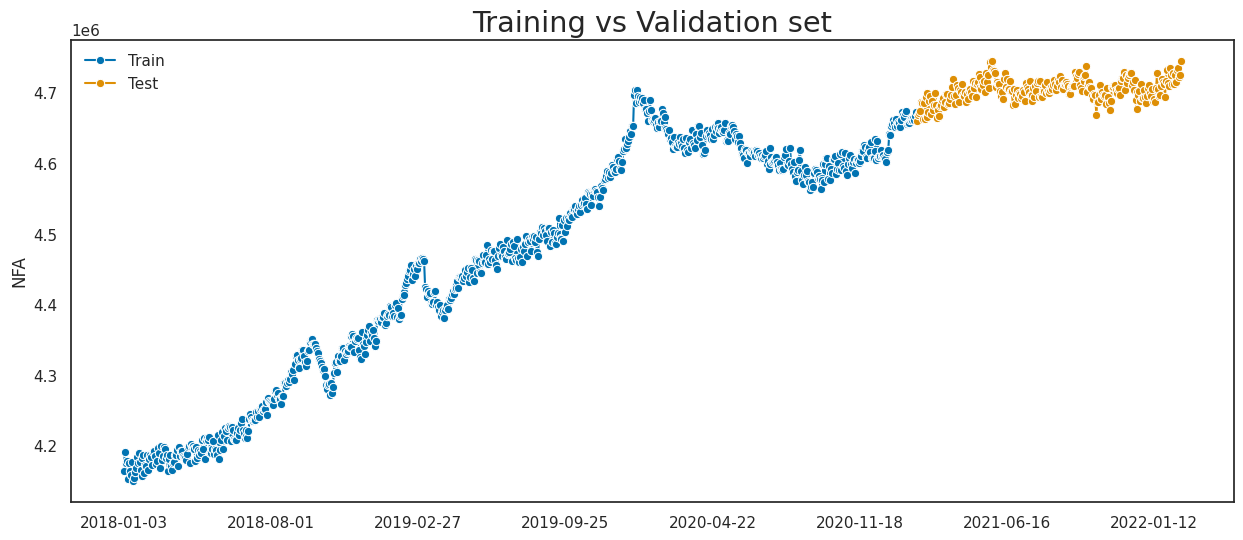

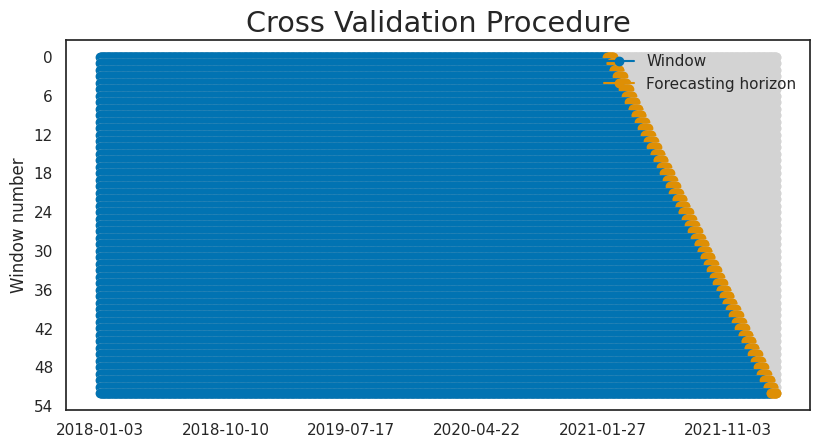

In [7]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')
plt.savefig(os.path.join(output_folder, f'train_test_{today}.png'), dpi=300)
model.plot_cv_procedure(xlabel='')
plt.savefig(os.path.join(output_folder, f'cross_validation_{today}.png'), dpi=300)

### Out-Of-sample Evaluation

In [8]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.039 minutes

Start Seasonal_Naive forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a Dat

Evaluation completed in: 0.022 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/joblib/parallel.py:598: FitFailedWarning: 
                In evaluate, fitting of forecaster StatsForecastAutoARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 23-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=923.
                The score will be set to nan.
                Failed forecaster with parameters: StatsForecastAutoARIMA(max_D=5, max_p=10, max_q=10, trend=False).
                
  return [func(*args, **kwargs)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/joblib/parallel.py:598: FitFailedWarning: 
                In evaluate, fitting of forecaster StatsForecastAutoARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 39-th d

Evaluation completed in: 0.024 minutes
Error evaluating AutoARIMA: cannot concatenate object of type '<class 'pandas._libs.missing.NAType'>'; only Series and DataFrame objs are valid

model AutoARIMA cannot be evaluated. It will be removed from the list of models

Start AutoETS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.342 minutes

Start AutoCES forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.403 minutes

Start AutoTheta forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.35 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated

Evaluation completed in: 0.322 minutes

Start GARCH forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: Period with BDay freq is deprecated and will be removed in a f

Evaluation completed in: 0.017 minutes

Start Prophet forecaster evalution....


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plot

Evaluation completed in: 0.027 minutes


In [9]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoTheta,53,14.557766,0.21016,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12289.042138,10352.961421,0.002201,-0.801601,9432.044529
GARCH,53,0.537444,0.006129,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12347.580836,10380.304507,0.002207,-0.835554,9341.460007
AutoTBATS,53,17.083697,0.005133,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12363.074612,10451.414764,0.002222,-0.843738,9444.130242
AutoETS,53,19.850024,0.383839,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12380.3787,10484.706172,0.00223,-0.855107,9618.252984
AutoCES,53,23.294988,0.251647,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12413.604141,10521.989204,0.002238,-0.869003,9679.172505
Naive,53,0.003541,0.042196,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12833.157323,10817.871698,0.0023,-1.103052,9999.424528
Seasonal_Naive,53,0.003263,0.03077,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,15235.466272,12721.271698,0.002704,-1.922647,11684.754717
Prophet,53,0.51656,0.04766,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,15590.705865,13594.530965,0.00289,-2.577685,12619.675303


horizon                            1             2             3   \
Naive          RMSE      13121.914843  13155.879256  14151.363753   
               MAE       10396.849057  10476.886792  10978.188679   
               MAPE          0.002211      0.002228      0.002333   
               R2            0.384190      0.255587      0.062300   
               MedianAE  10411.000000   8288.000000   7935.000000   
Seasonal_Naive RMSE      15153.803337  14859.930900  15193.757252   
               MAE       12090.169811  12326.037736  12530.490566   
               MAPE          0.002569      0.002619      0.002662   
               R2            0.178712      0.050254     -0.080930   
               MedianAE  11451.000000  11196.000000  13093.000000   
AutoETS        RMSE      11640.432544  11860.255138  12318.536914   
               MAE        9297.351335   9875.111633  10007.968520   
               MAPE          0.001976      0.002099      0.002127   
               R2            0.515392      0.394991      0.289465   
               MedianAE   8571.378353   9023.960651   9046.172771   
AutoCES        RMSE      11641.713660  11817.249250  12315.819265   
               MAE        9328.156045   9844.573929  10038.152298   
               MAPE          0.001983      0.002093      0.002134   
               R2            0.515286      0.399370      0.289779   
               MedianAE   8534.000000   8978.500000   8949.000000   
AutoTheta      RMSE      11770.189579  11875.943610  12339.609854   
               MAE        9368.899314   9869.504805  10023.320128   
               MAPE          0.001992      0.002098      0.002130   
               R2            0.504528      0.393389      0.287032   
               MedianAE   8131.247120   8888.261138   8851.359322   
AutoTBATS      RMSE      11665.029406  11940.342717  12300.477214   
               MAE        9346.328259   9958.758782   9892.763947   
               MAPE          0.001987      0.002117      0.002102   
               R2            0.513342      0.386792      0.291547   
               MedianAE   8515.886591   9771.436188   8496.789358   
GARCH          RMSE      11631.593490  12030.045466  12356.847676   
               MAE        9305.063602  10077.343557   9929.747161   
               MAPE          0.001978      0.002142      0.002110   
               R2            0.516128      0.377544      0.285039   
               MedianAE   8998.111090   9869.617914   8924.495999   
Prophet        RMSE      15117.062598  15153.295593  13343.380455   
               MAE       12348.241353  13154.620486  10269.695609   
               MAPE          0.002625      0.002796      0.002183   
               R2            0.182690      0.012384      0.166321   
               MedianAE  10681.011764  13436.905594   7408.650711   

horizon                            4             5             6   \
Naive          RMSE      13886.083736  12572.023201  14534.760444   
               MAE       11179.735849   9846.150943  12351.811321   
               MAPE          0.002379      0.002093      0.002625   
               R2            0.362252     -0.108799      0.181963   
               MedianAE  10368.000000   8173.000000  11618.000000   
Seasonal_Naive RMSE      16459.882093  12572.023201  17286.325221   
               MAE       13366.075472   9846.150943  13962.943396   
               MAPE          0.002842      0.002093      0.002967   
               R2            0.103927     -0.108799     -0.157078   
               MedianAE  10552.000000   8173.000000  12571.000000   
AutoETS        RMSE      13979.287573  12120.180124  14376.248903   
               MAE       10858.327365   9414.842995  12075.228704   
               MAPE          0.002311      0.002002      0.002567   
               R2            0.353662     -0.030530      0.199708   
               MedianAE   9332.488568   8214.423566  11465.292750   
AutoCES        RMSE      14027.532312  12135.373104  14442.151872 

In [18]:
rank, score = model.select_best(score = 'RMSE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,GARCH,AutoCES,AutoTBATS,AutoTheta,AutoTheta,AutoTheta,Naive,GARCH,Naive,Naive
Best_2,AutoETS,AutoETS,AutoCES,GARCH,AutoETS,GARCH,AutoTheta,AutoTheta,GARCH,Seasonal_Naive
Best_3,AutoCES,AutoTheta,AutoETS,AutoTBATS,AutoCES,AutoETS,AutoETS,AutoTBATS,AutoTheta,AutoTheta
Best_4,AutoTBATS,AutoTBATS,AutoTheta,Naive,AutoTBATS,AutoTBATS,AutoTBATS,AutoETS,AutoTBATS,GARCH
Best_5,AutoTheta,GARCH,GARCH,AutoETS,GARCH,AutoCES,AutoCES,AutoCES,AutoETS,AutoTBATS
Best_6,Naive,Naive,Prophet,AutoCES,Seasonal_Naive,Naive,GARCH,Naive,AutoCES,AutoETS
Best_7,Prophet,Seasonal_Naive,Naive,Seasonal_Naive,Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,AutoCES
Best_8,Seasonal_Naive,Prophet,Seasonal_Naive,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet


,Naive,Seasonal_Naive,AutoETS,AutoCES,AutoTheta,AutoTBATS,GARCH,Prophet,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,,
1,13121.914843,15153.803337,11640.432544,11641.713660,11770.189579,11665.029406,11631.593490,15117.062598,11770.189579,11631.593490,11700.891534,11636.013017,12717.717432
2,13155.879256,14859.930900,11860.255138,11817.249250,11875.943610,11940.342717,12030.045466,15153.295593,11875.943610,11817.249250,11952.994538,11838.752194,12836.617741
3,14151.363753,15193.757252,12318.536914,12315.819265,12339.609854,12300.477214,12356.847676,13343.380455,12339.609854,12300.477214,12348.228765,12308.148240,13039.974048
4,13886.083736,16459.882093,13979.287573,14027.532312,13576.464926,13789.621335,13607.786850,16739.526836,13576.464926,13576.464926,13592.125888,13592.125888,14508.273207
5,12572.023201,12572.023201,12120.180124,12135.373104,12083.963344,12154.608592,12169.757512,15273.473166,12083.963344,12083.963344,12126.860428,12102.071734,12635.175281
6,14534.760444,17286.325221,14376.248903,14442.151872,14239.301273,14410.880797,14305.731321,18679.022105,14239.301273,14239.301273,14272.516297,14272.516297,15284.302742
7,13184.141563,17886.854156,13454.230500,13540.711035,13342.659895,13489.180741,13570.921333,19094.643135,13342.659895,13184.141563,13456.790614,13263.400729,14695.417795
8,12843.956942,16247.474337,12561.178231,12622.138542,12243.551368,12294.246933,12190.680538,16930.782544,12243.551368,12190.680538,12217.115953,12217.115953,13491.751179
9,14314.535407,19098.407409,16189.634212,16224.921601,15267.653001,15711.777441,15224.967653,20659.045323,15267.653001,14314.535407,15246.310327,14769.751530,16586.367756


In [11]:
# export all the result in excel 
with pd.ExcelWriter(os.path.join(output_folder, f'Cross_validation_result_{today}.xlsx')) as writer:
    summary_results.to_excel(writer, sheet_name='summary_results', index=True)
    summary_horizon.to_excel(writer, sheet_name='summary_horizon', index=True)
    rank.to_excel(writer, sheet_name='rank', index=True)
    score.to_excel(writer, sheet_name='score', index=True)

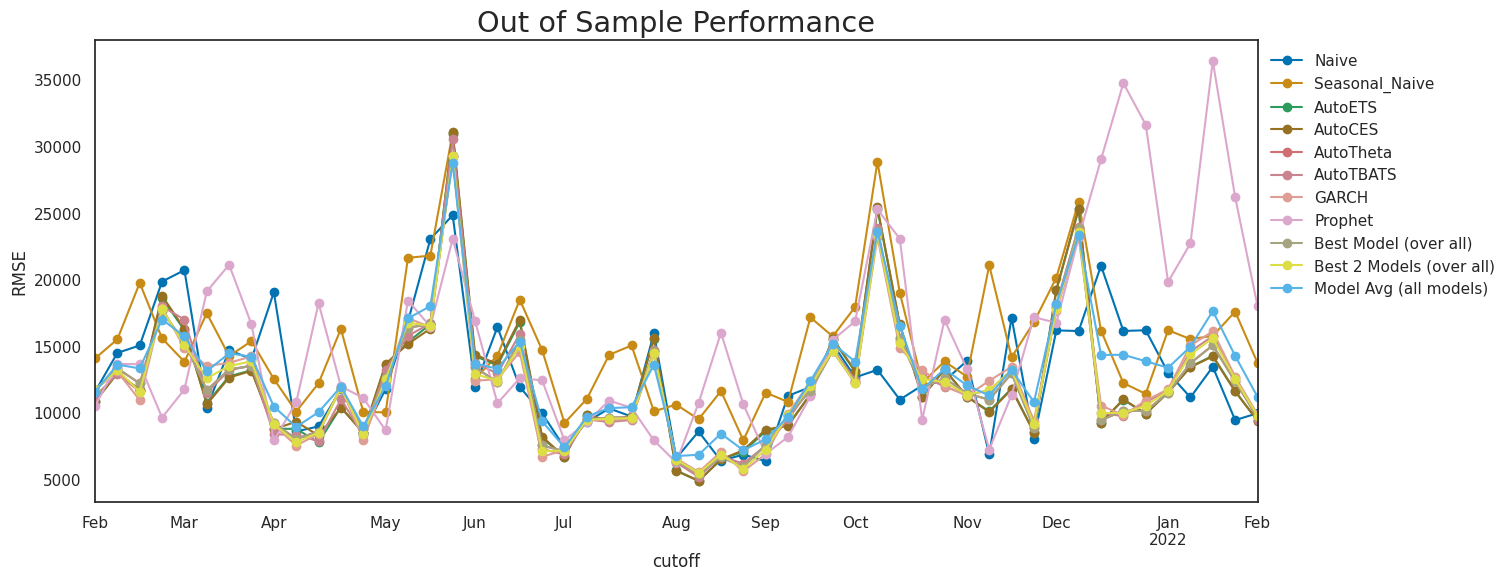

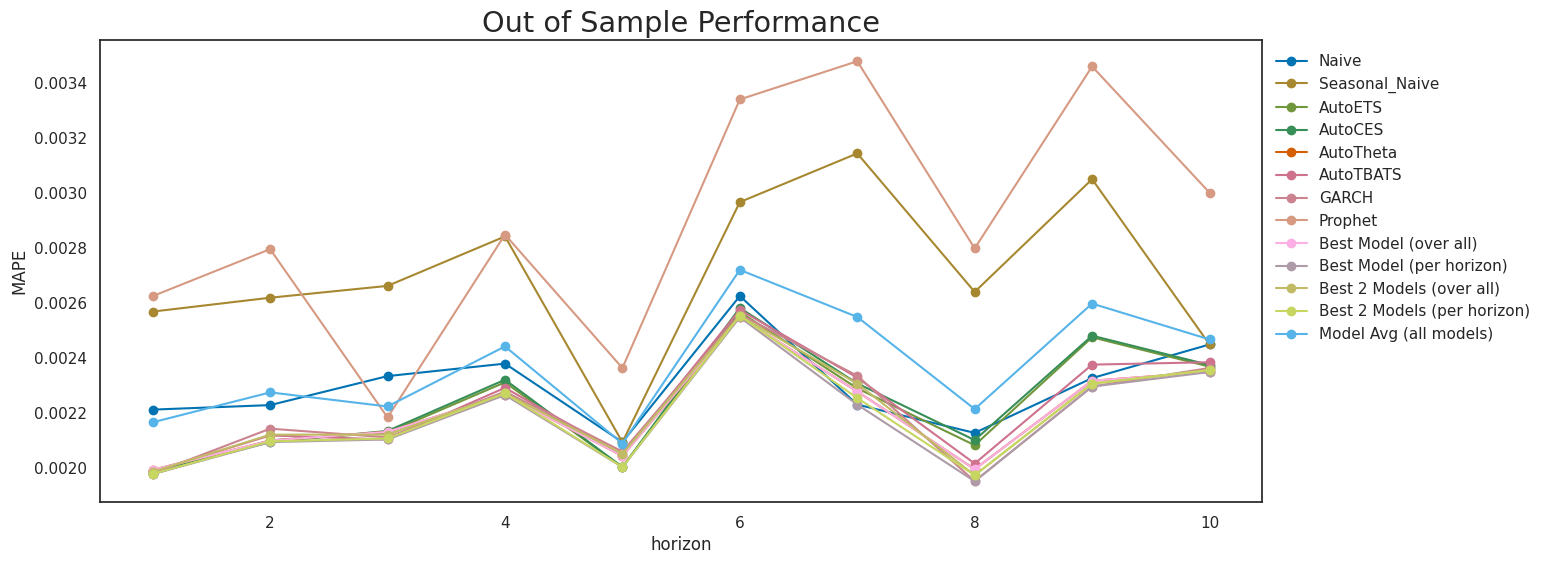

In [19]:
subset = ['AutoCES', 'AutoTheta', 'AutoTBATS', 'GARCH']
model.plot_model_compare(score ='RMSE', view = 'cutoff')#, model_subset=subset)
plt.savefig(os.path.join(output_folder, f'model_compare_per_cutoff_{today}.png'), dpi=300, bbox_inches='tight')
model.plot_model_compare(score ='MAPE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])
plt.savefig(os.path.join(output_folder, f'model_compare_per_horizon_{today}.png'), dpi=300, bbox_inches='tight')

In [13]:
model.fit(verbose = True)

Fitting Naive ...
Fitting Seasonal_Naive ...
Fitting AutoETS ...


Fitting AutoCES ...
Fitting AutoTheta ...
Fitting AutoTBATS ...


19:13:41 - cmdstanpy - INFO - Chain [1] start processing


Fitting GARCH ...
Fitting Prophet ...


19:13:41 - cmdstanpy - INFO - Chain [1] done processing


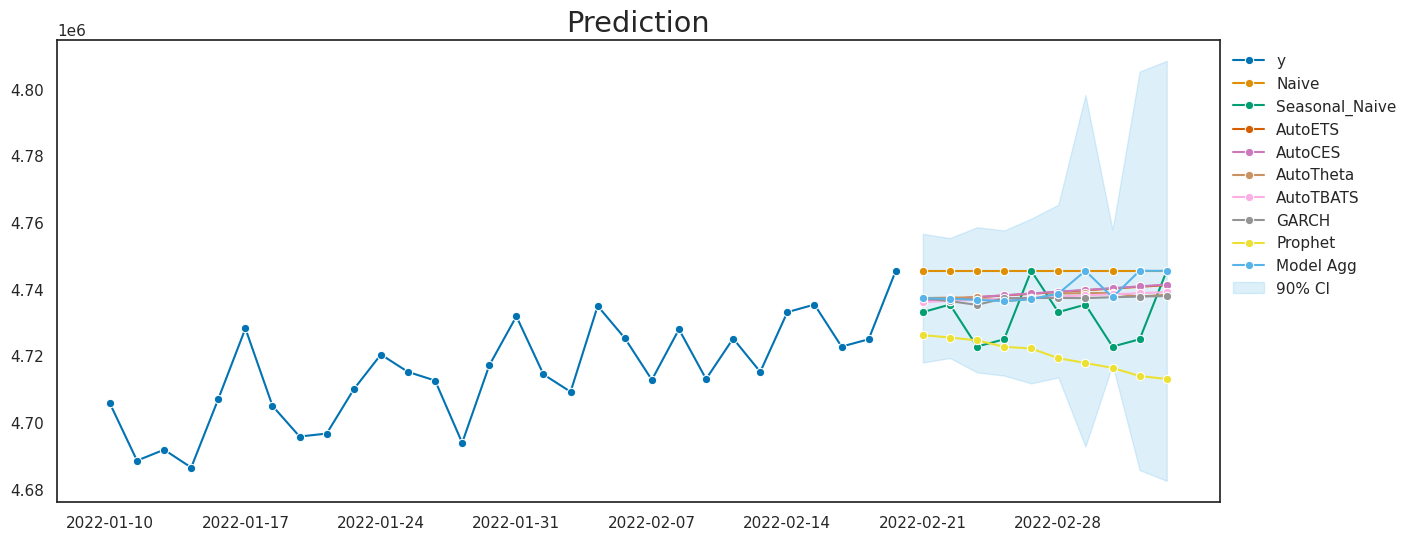

In [14]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(X=exogs, 
                                                    mode='best_horizon',
                                                    ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     y_pred_interval = y_pred_ints)                 

In [20]:
path = '../model_output/NFA_forecast.pkl'
model.save(path)